# Download a data file from the UCL server

We're using a small [example data set](http://data.cortexlab.net/singlePhase3/) recorded by [Nick Steinmetz](http://www.nicksteinmetz.com/) at UCL.

In [1]:
import urllib.request
file_url = 'http://data.cortexlab.net/singlePhase3/data/rawDataSample.bin'
file_name = "rawDataSample.bin"

urllib.request.urlretrieve(file_url, file_name)

('rawDataSample.bin', <http.client.HTTPMessage at 0x1041047b8>)

# Use of the `HSDetection` class

In [1]:
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import NeuroPixel
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# raw data file (as downloaded above)
data_path = "rawDataSample.bin"

# detection parameters
file_directory = 'results/'
file_name = 'ProcessedSpikesNeuropixel'

In [5]:
Probe = NeuroPixel(data_path, neighbor_radius=120,
                   masked_channels=[36, 75, 112, 151, 188, 227, 264, 303, 340, 379, 384])

H = HSDetection(Probe, num_com_centers=2, threshold=20,
                left_cutout_time=0.4, right_cutout_time=1.0,
                maa=0, amp_evaluation_time=0.1, spk_evaluation_time=0.4,
                ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, decay_filtering=True, save_all=True)

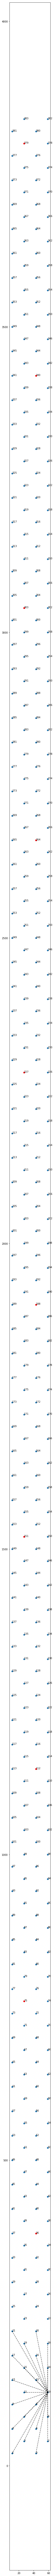

In [8]:
Probe.show()

In [6]:
H.DetectFromRaw()

# Masking Channels: [36, 75, 112, 151, 188, 227, 264, 303, 340, 379, 384]
# Sampling rate: 30000
# Localization On
# Writing out extended detection info
# Number of recorded channels: 385
# Analysing frames: 1800000; Seconds: 60.0
# Frames before spike in cutout: 12
# Frames after spike in cutout: 30
# MaxSl: 12
# MinSl: 3
# tcuts: 24 42
# tInc: 50000
# Analysing frames from -24 to 50042  (0.0%)
# Analysing frames from 49976 to 100042  (2.8%)
# Analysing frames from 99976 to 150042  (5.6%)
# Analysing frames from 149976 to 200042  (8.3%)
# Analysing frames from 199976 to 250042  (11.1%)
# Analysing frames from 249976 to 300042  (13.9%)
# Analysing frames from 299976 to 350042  (16.7%)
# Analysing frames from 349976 to 400042  (19.4%)
# Analysing frames from 399976 to 450042  (22.2%)
# Analysing frames from 449976 to 500042  (25.0%)
# Analysing frames from 499976 to 550042  (27.8%)
# Analysing frames from 549976 to 600042  (30.6%)
# Analysing frames from 599976 to 650042  (33.3%)
# Anal

In [7]:
H.LoadDetected()

Detected and read 131433 spikes.


Spike detected at channel:  353
Spike detected at frame:  217
Spike localised in position 35.525 3573.855
trange (100,)
Data (100, 385)


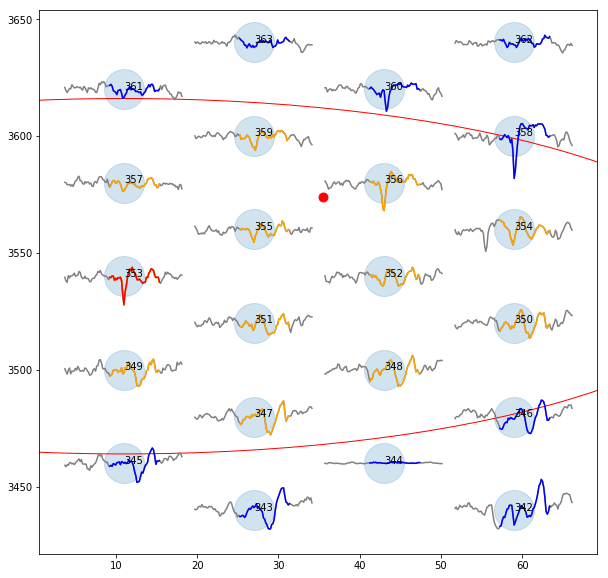

In [8]:
plt.figure(figsize=(10, 10))
H.PlotTracesChannels(15, window_size=100)

We have 131433 spikes, only showing 100000


(0, 600)

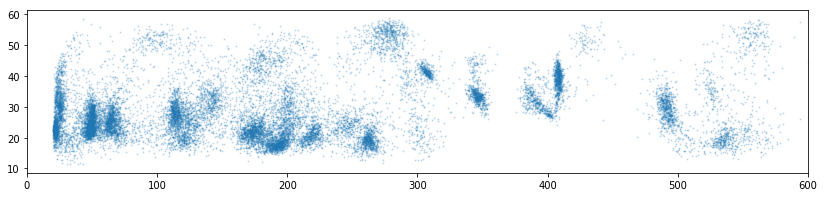

In [9]:
plt.figure(figsize=(14, 3))
ax = plt.subplot(111)
H.PlotAll(invert=True, s=1, alpha=0.2, ax=ax)
ax.set_xlim((0,600))

# Use of the `HSClustering` class

In [10]:
from herdingspikes.hs2 import HSClustering

# Load from file
#C = Clustering(['results/ProcessedSpikes_mea1k.bin', 'results/ProcessedSpikes_mea1k.bin'], cutout_length=41)

# Or if the spikes are already in memory
# simply load from the Detection class
C = HSClustering(H)

In [11]:
%%time
# Compute features
C.ShapePCA(pca_ncomponents=2, pca_whiten=True);

Fitting PCA using 131433 spikes...
...projecting...
...done
CPU times: user 1.92 s, sys: 283 ms, total: 2.2 s
Wall time: 1.07 s


In [12]:
%%time
# Cluster all spikes

# This shows how a (potentially relatively small) subset of spikes 
# can be used to form clusters. All spikes are then assigned
# to these clusters in batches. This allows clustering of very large 
# recordings (also multiple files) without exhausting memory.

C.CombinedClustering(alpha=7, bandwidth=5.0, bin_seeding=False, n_jobs=-1, cluster_subset=100000)

Clustering...
Clustering using 100000 out of 131433 spikes...
number of seeds: 100000
seeds/job: 25001
using 4 cpus


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  7.9min finished


Number of estimated units: 5233
Predicting cluster labels for 131433 spikes...
predicting
CPU times: user 13.6 s, sys: 2.59 s, total: 16.1 s
Wall time: 8min 9s


We have 131433 spikes, only showing 100000


(0, 600)

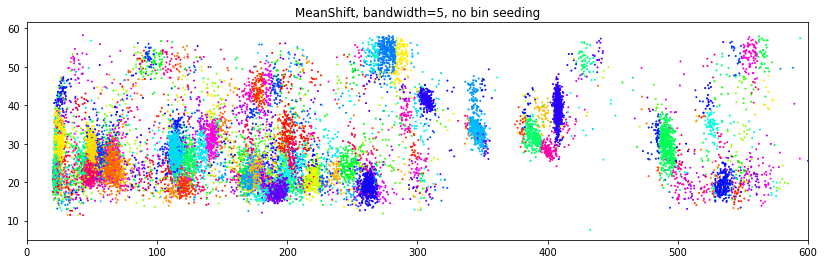

In [13]:
plt.figure(figsize=(20, 2))
ax = plt.subplot(111)
C.PlotAll(invert=True, s=1, ax=ax, max_show=100000, show_labels=False)
plt.title("MeanShift, bandwidth=5, no bin seeding");
ax.set_xlim((0,600))


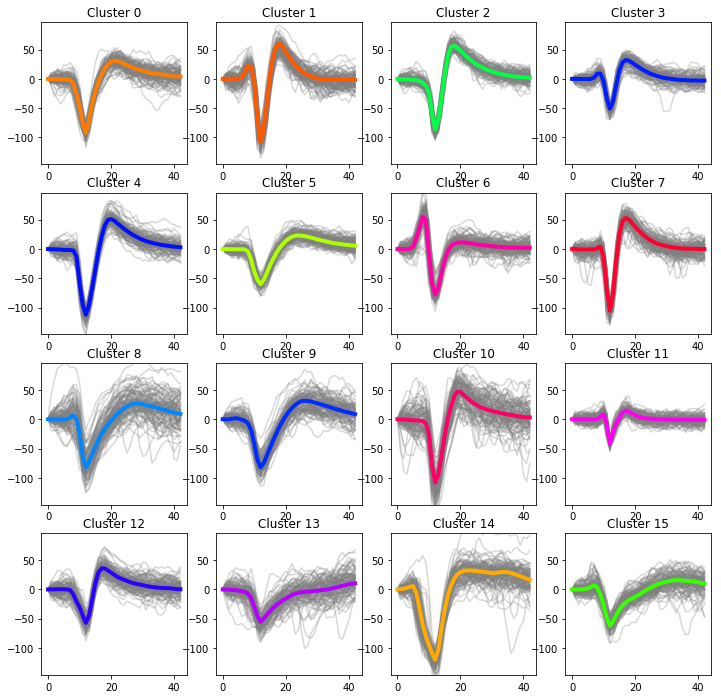

In [14]:
units = range(16)
C.PlotShapes(units)

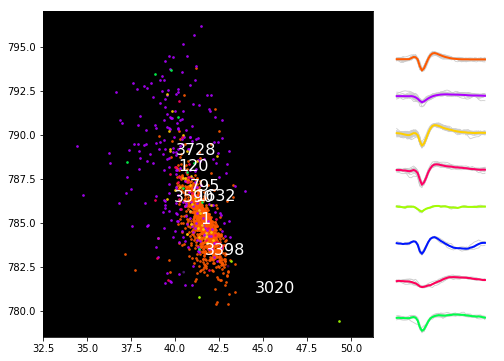

In [15]:
C.PlotNeighbourhood(1, radius=6, alpha=0.8);

In [26]:
# Save the results

C.SaveHDF5(file_name+"_sorted.hdf5")